# Forces

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
sys.path.insert(0, '../../../icenumerics/')
sys.path.insert(0, './../auxnumerics/')
sys.path.insert(0, '../')
import icenumerics as ice


from parameters import params
import auxiliary as aux
import montecarlo_colloids as mc
import vertices as vrt

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice


In [81]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

In [6]:
def geometrical_part(r,B):
    """ 
        Geometrical part of the force 
        (rxB)xB - 2r + 5r (rxB)^2
    """
    rcb = np.cross(r,B)
    return 2*np.cross(rcb,B) - 2*r + 5*r*np.dot(rcb,rcb)

def get_forces(params, positions, Bhat = [1,0,0]):
    """
        Compute the total force on all the particles
    """
    
    # get the dimensional part in pN * nm
    factor = (3*params['mu0']*params['m']**2)/(4*np.pi)
    factor = factor.to(ureg.piconewton * ureg.micrometer**4)
    
    forces = [] # init
    
    # loop all particles
    for i,r1 in enumerate(positions):

        force = np.array([0,0,0])*ureg.piconewton

        # get the contribution from all particles to particle i
        for j,r2 in enumerate(positions):

            R = r1 - r2 
            distance = np.linalg.norm(R)
            
            # the algorithm eventually gets to itself, 
            # so I just want to skip this case
            if distance == 0:
                continue

            rhat = R/distance 
            distance = distance*ureg.um
            force = force + factor/distance**4 * geometrical_part(rhat,Bhat)

        forces.append(force.magnitude) 
    return np.asarray(forces)

#  Verifying the vertices files

In [7]:
DRIVE = '/home/frieren/BIG/'
PROJECT = 'reentrancy/states'

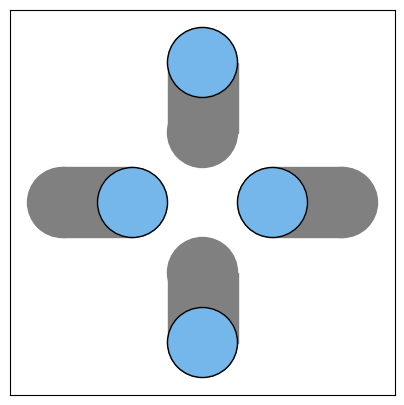

In [20]:
trj = pd.read_csv(os.path.join(DRIVE,PROJECT,'type3.csv'),index_col='id')
trj = vrt.trj2trj(trj)
trj[['dx','dy','dz']] = trj[['dx','dy','dz']].apply(lambda x: params['trap_sep'].magnitude*x)

fig, ax = plt.subplots(figsize=(5,5))
ice.draw_frame(trj, frame_no=0,
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)

plt.show()

In [77]:
def import_and_correct(params,filepath):
    """ Imports the trj and corrects the dx dy dz to include the trap sep """
    trj = vrt.trj2trj( pd.read_csv(filepath,index_col=['id']) )
    trj[['dx','dy','dz']] = trj[['dx','dy','dz']].apply(lambda x: params['trap_sep'].magnitude*x)
    return trj

def get_positions(trj):
    """ Gets a matrix where each row contains [x,y,z] for particle i """
    x = (trj['x'] + trj['cx']).to_numpy()
    y = (trj['y'] + trj['cy']).to_numpy()
    z = (trj['z'] + trj['cz']).to_numpy()
    return  np.vstack([x,y,z]).T

def forces_elements(params, positions, Bhat):
    """ Compute the forces and returns the directions and magnitudes """
    forces = get_forces(params,positions, Bhat=Bhat)
    fdirs = np.asarray([f/np.linalg.norm(f) for f in forces])
    mags = np.round( np.array([np.linalg.norm(f) for f in forces]),4)

    return fdirs, mags
    

In [78]:
names = ['16','25','3','4']
files = ['q4.csv','q2.csv','type3.csv','type4.csv']

# import the trajectories
topology = {
    f"trj{name}":import_and_correct(params,os.path.join(DRIVE,PROJECT,file)) for (name,file) in zip(names,files)
}

# add the positions
topology = topology | {
    f"pos{name}":get_positions(topology[f"trj{name}"]) for name in names
}

stuff.keys()

dict_keys(['trj16', 'trj25', 'trj3', 'trj4', 'pos16', 'pos25', 'pos3', 'pos4'])

In [123]:
angles = np.round(np.arange(0,np.pi/2,0.01),3)
fields = [[np.sin(theta),0,np.cos(theta)] for theta in angles]
angles

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

In [125]:
fig, axes = plt.subplots(1,4,figsize=(15,5))

for i,(B,theta) in enumerate(zip(fields,angles)):
    
    # forces and magnitudes separately
    fm = {f"fm{name}": forces_elements(params, topology[f"pos{name}"], Bhat=B) for name in names }

    for j,name in enumerate(names):
        ax = axes[j]
        
        # put the angle only in the first one
        if j==0:
            ax.set_title(f'$\\theta = {theta * 180/np.pi:.2f}$',fontsize=20)
            
        ice.draw_frame(topology[f'trj{name}'], frame_no=0,
                       radius=params["particle_radius"].magnitude,
                       cutoff=params["trap_sep"].magnitude/2,
                       particle_color='#75b7ea',
                       trap_color='gray',
                       ax = ax)

        positions = topology[f'pos{name}']
        fdirs,mags = fm[f'fm{name}']
        forces = fdirs * mags[:,np.newaxis]
        ax.quiver(positions[:,0],positions[:,1],forces[:,0],forces[:,1])

    fig.savefig(os.path.join(DRIVE,'reentrancy/forces',f'{i}.png'), bbox_inches='tight')
    plt.close(fig)